In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import pickle
from dataclasses import dataclass
from functools import lru_cache, partial

In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset

from pytorch_lightning.utilities.model_summary import summarize
from datasets import load_dataset
from datasets.iterable_dataset import RandomlyCyclingMultiSourcesExamplesIterable


from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset, Dataset, DatasetCollection, Cached
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    SecondOfMinute,
    MinuteOfHour,
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    WeekOfYear,
    MonthOfYear,
    DayOfYear,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddTimeFeatures,
    Chain,
)

from estimator import TransformerEstimator

In [3]:
time_features = [
    MinuteOfHour(),
    HourOfDay(),
    DayOfWeek(),
    DayOfMonth(),
    WeekOfYear(),
    MonthOfYear(),
    DayOfYear(),
]

In [4]:
@lru_cache
def as_period(val, freq):
    return pd.Period(val, freq)

In [5]:
@dataclass
class GluontsDataset(Dataset):
    def __init__(self, dataset, freq, prediction_length=24) -> None:
        super().__init__()
        transform = Chain([
             AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=time_features,
                    pred_length=prediction_length,
                ),
                AddAgeFeature(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_AGE,
                    pred_length=prediction_length,
                    log_scale=True,
                ),
        ])

        self.dataset = Cached(transform.apply(dataset))
        self.freq = to_offset(freq)
        self.prediction_length = prediction_length

    def __iter__(self):
        for data in self.dataset:
            if len(data[FieldName.TARGET]) > self.prediction_length:
                yield {
                    FieldName.START: as_period(data[FieldName.START], self.freq),
                    FieldName.TARGET: data[FieldName.TARGET],
                    FieldName.FEAT_TIME: np.stack(data[FieldName.FEAT_TIME], 0),
                    FieldName.FEAT_AGE: np.stack(data[FieldName.FEAT_AGE], 0),
                    FieldName.ITEM_ID: data[FieldName.ITEM_ID],
                }

    def __len__(self):
        return len(self.dataset)

In [6]:
prediction_length  = 24

In [7]:
dataset_1 = get_dataset("electricity")
train_ds_1 = GluontsDataset(dataset_1.train, dataset_1.metadata.freq, prediction_length)
test_ds_1 = GluontsDataset(dataset_1.test, dataset_1.metadata.freq, prediction_length)

In [8]:
dataset_2 = get_dataset("traffic")
train_ds_2 = GluontsDataset(dataset_2.train, dataset_2.metadata.freq, prediction_length)
test_ds_2 = GluontsDataset(dataset_2.test, dataset_2.metadata.freq, prediction_length)

In [9]:
dataset_3 = get_dataset("m4_hourly")
train_ds_3 = GluontsDataset(dataset_3.train, dataset_3.metadata.freq, prediction_length)
test_ds_3 = GluontsDataset(dataset_3.test, dataset_3.metadata.freq, prediction_length)

In [10]:
dataset_4 = get_dataset("m4_daily")
train_ds_4 = GluontsDataset(dataset_4.train, dataset_4.metadata.freq, prediction_length)
test_ds_4 = GluontsDataset(dataset_4.test, dataset_4.metadata.freq, prediction_length)

In [11]:
dataset_5 = get_dataset("m4_weekly")
train_ds_5 = GluontsDataset(dataset_5.train, dataset_5.metadata.freq, prediction_length)
test_ds_5 = GluontsDataset(dataset_5.test, dataset_5.metadata.freq, prediction_length)

In [12]:
dataset_6 = get_dataset("m4_monthly")
train_ds_6 = GluontsDataset(dataset_6.train, dataset_6.metadata.freq, prediction_length)
test_ds_6 = GluontsDataset(dataset_6.test, dataset_6.metadata.freq, prediction_length)

In [13]:
dataset_7 = get_dataset("m4_quarterly")
train_ds_7 = GluontsDataset(dataset_7.train, dataset_7.metadata.freq, prediction_length)
test_ds_7 = GluontsDataset(dataset_7.test, dataset_7.metadata.freq, prediction_length)

In [14]:
dataset_8 = get_dataset("solar-energy")
train_ds_8 = GluontsDataset(dataset_8.train, dataset_8.metadata.freq, prediction_length)
test_ds_8 = GluontsDataset(dataset_8.test, dataset_8.metadata.freq, prediction_length)

In [15]:
dataset_9 = get_dataset("nn5_daily_with_missing")
train_ds_9 = GluontsDataset(dataset_9.train, dataset_9.metadata.freq, prediction_length)
test_ds_9 = GluontsDataset(dataset_9.test, dataset_9.metadata.freq, prediction_length)

In [44]:
#train_ds_list = [train_ds_1, train_ds_2, train_ds_3, train_ds_4, train_ds_5, train_ds_6, train_ds_7, train_ds_8, train_ds_9]

train_ds_list = [ train_ds_7, train_ds_9]

train_ds_size = np.array([len(ds) for ds in train_ds_list])
raw_weights = 1/train_ds_size
normalization_factor = 1/sum(raw_weights)
probabilities = raw_weights * normalization_factor

In [48]:
probabilities

array([0.00460371, 0.99539629])

In [81]:
train_ds = RandomlyCyclingMultiSourcesExamplesIterable(train_ds_list,
    generator=np.random.default_rng(),
    probabilities=[7/8, 1/8],

    )

In [18]:
#val_ds = ListDataset(dataset["validation"], freq=freq)

In [19]:
test_ds = DatasetCollection([test_ds_1, test_ds_2, test_ds_3, test_ds_4, test_ds_5, test_ds_6, test_ds_7, test_ds_8, test_ds_9], interleave=False)

In [82]:
estimator = TransformerEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*10,
    time_features=time_features,
    lags_seq=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 24, 30, 31, 60,],

    nhead=2,
    num_encoder_layers=6,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",

    scaling=True,

    batch_size=256,
    num_batches_per_epoch=200,
    trainer_kwargs=dict(max_epochs=100, accelerator='auto', gpus=1, precision="bf16"),
    )
    
predictor = estimator.train(
    training_data=train_ds,
    num_workers=8,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `va

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached 4.98559 (best 4.98559), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_231/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached 4.47942 (best 4.47942), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_231/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' reached 4.36116 (best 4.36116), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_231/checkpoints/epoch=2-step=600.ckpt' as top 1
Epoch 3, global step 800: 'train_loss' reached 4.28687 (best 4.28687), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_231/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' reached 4.22772 (best 4.22772), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/

In [88]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds_7, 
    predictor=predictor
)

In [89]:
tss = list(ts_it)

In [90]:
forecasts = list(forecast_it)
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 23999it [00:00, 25530.68it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [91]:
agg_metrics

{'MSE': 6089164.112834062,
 'abs_error': 862829152.6037445,
 'abs_target_sum': 3281838171.394043,
 'abs_target_mean': 5697.873125606003,
 'seasonal_error': 449.9906981187095,
 'MASE': inf,
 'MAPE': 0.3499003577156683,
 'sMAPE': 0.24937755122297217,
 'MSIS': inf,
 'QuantileLoss[0.1]': 714553109.3695533,
 'Coverage[0.1]': 0.5964380460296957,
 'QuantileLoss[0.2]': 844497634.3922973,
 'Coverage[0.2]': 0.6849903468200064,
 'QuantileLoss[0.3]': 894367273.6482055,
 'Coverage[0.3]': 0.737357112101893,
 'QuantileLoss[0.4]': 896646554.0141907,
 'Coverage[0.4]': 0.7752875119796658,
 'QuantileLoss[0.5]': 862829152.3864899,
 'Coverage[0.5]': 0.806266233315277,
 'QuantileLoss[0.6]': 792564839.6213562,
 'Coverage[0.6]': 0.8307099601372281,
 'QuantileLoss[0.7]': 696374384.7592316,
 'Coverage[0.7]': 0.8563308193396947,
 'QuantileLoss[0.8]': 564508307.537567,
 'Coverage[0.8]': 0.8822277317110436,
 'QuantileLoss[0.9]': 383830228.334552,
 'Coverage[0.9]': 0.911419920274456,
 'RMSE': 2467.6231707523866,
 '

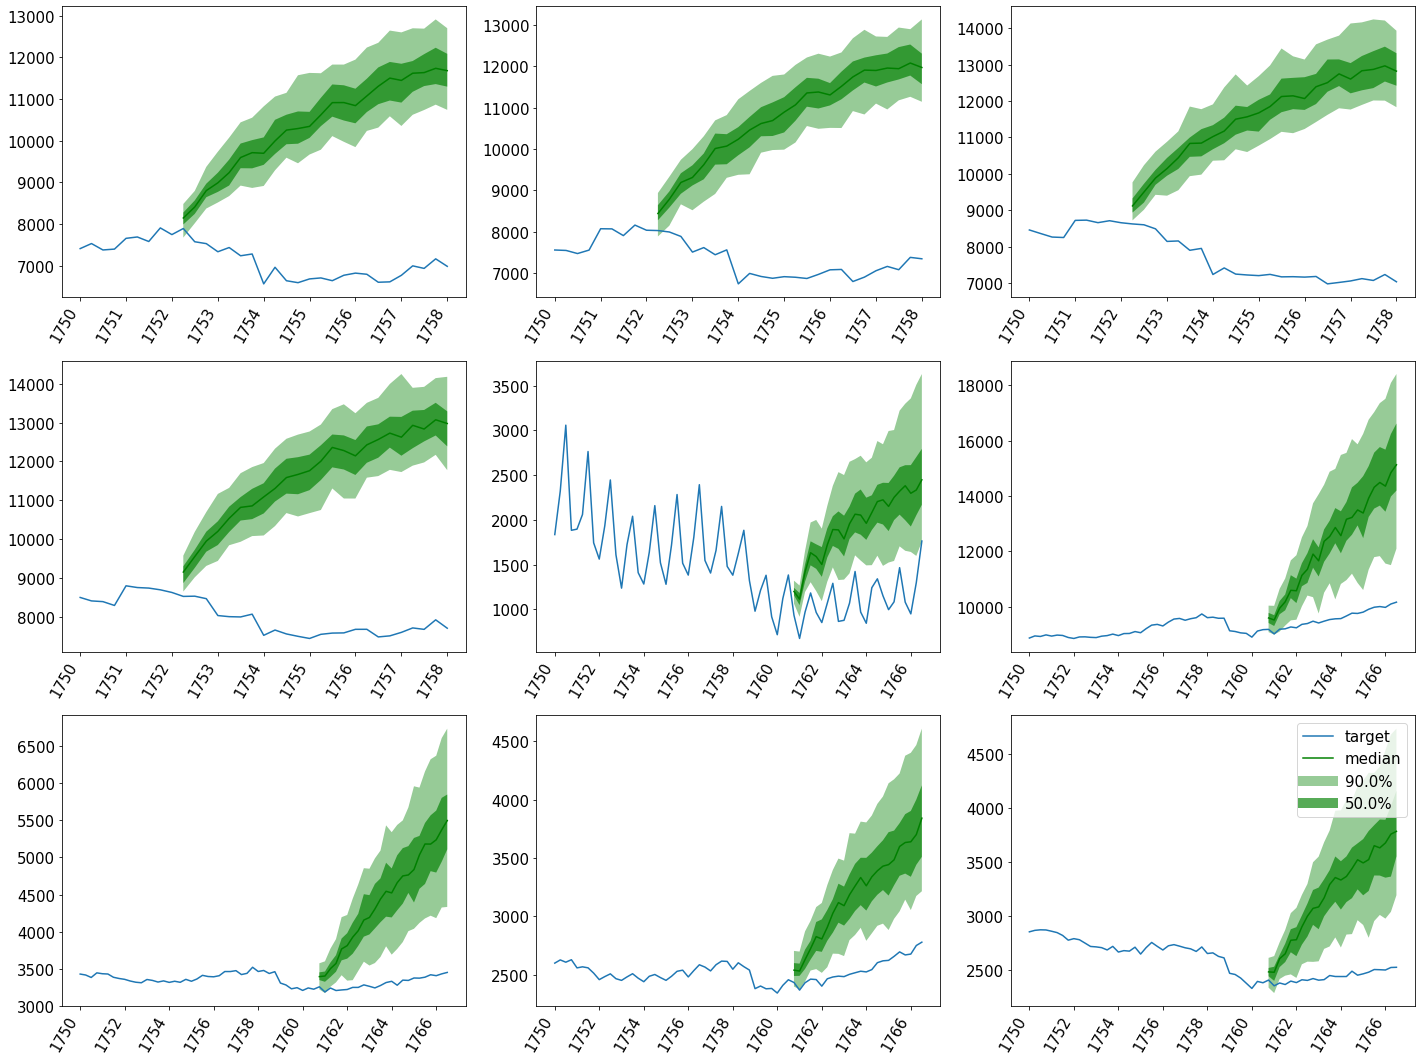

In [92]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [129]:
agg_metrics

{'MSE': 6377855.327358201,
 'abs_error': 805831889.9328613,
 'abs_target_sum': 3281838171.394043,
 'abs_target_mean': 5697.873125606003,
 'seasonal_error': 449.9906981187095,
 'MASE': inf,
 'MAPE': 0.32008362023628983,
 'sMAPE': 0.2694727060621601,
 'MSIS': inf,
 'QuantileLoss[0.1]': 459036993.23896635,
 'Coverage[0.1]': 0.3643953914746448,
 'QuantileLoss[0.2]': 601372778.1569703,
 'Coverage[0.2]': 0.4192188563412364,
 'QuantileLoss[0.3]': 697959345.8917251,
 'Coverage[0.3]': 0.45909030931844386,
 'QuantileLoss[0.4]': 764659020.0878601,
 'Coverage[0.4]': 0.4944910899065239,
 'QuantileLoss[0.5]': 805831889.460434,
 'Coverage[0.5]': 0.528377918524383,
 'QuantileLoss[0.6]': 823117551.84935,
 'Coverage[0.6]': 0.5607230162367877,
 'QuantileLoss[0.7]': 811753930.8299179,
 'Coverage[0.7]': 0.5997020709196217,
 'QuantileLoss[0.8]': 763773000.9127625,
 'Coverage[0.8]': 0.6463272775254525,
 'QuantileLoss[0.9]': 655477418.9614197,
 'Coverage[0.9]': 0.711137269608456,
 'RMSE': 2525.441610364057,
 

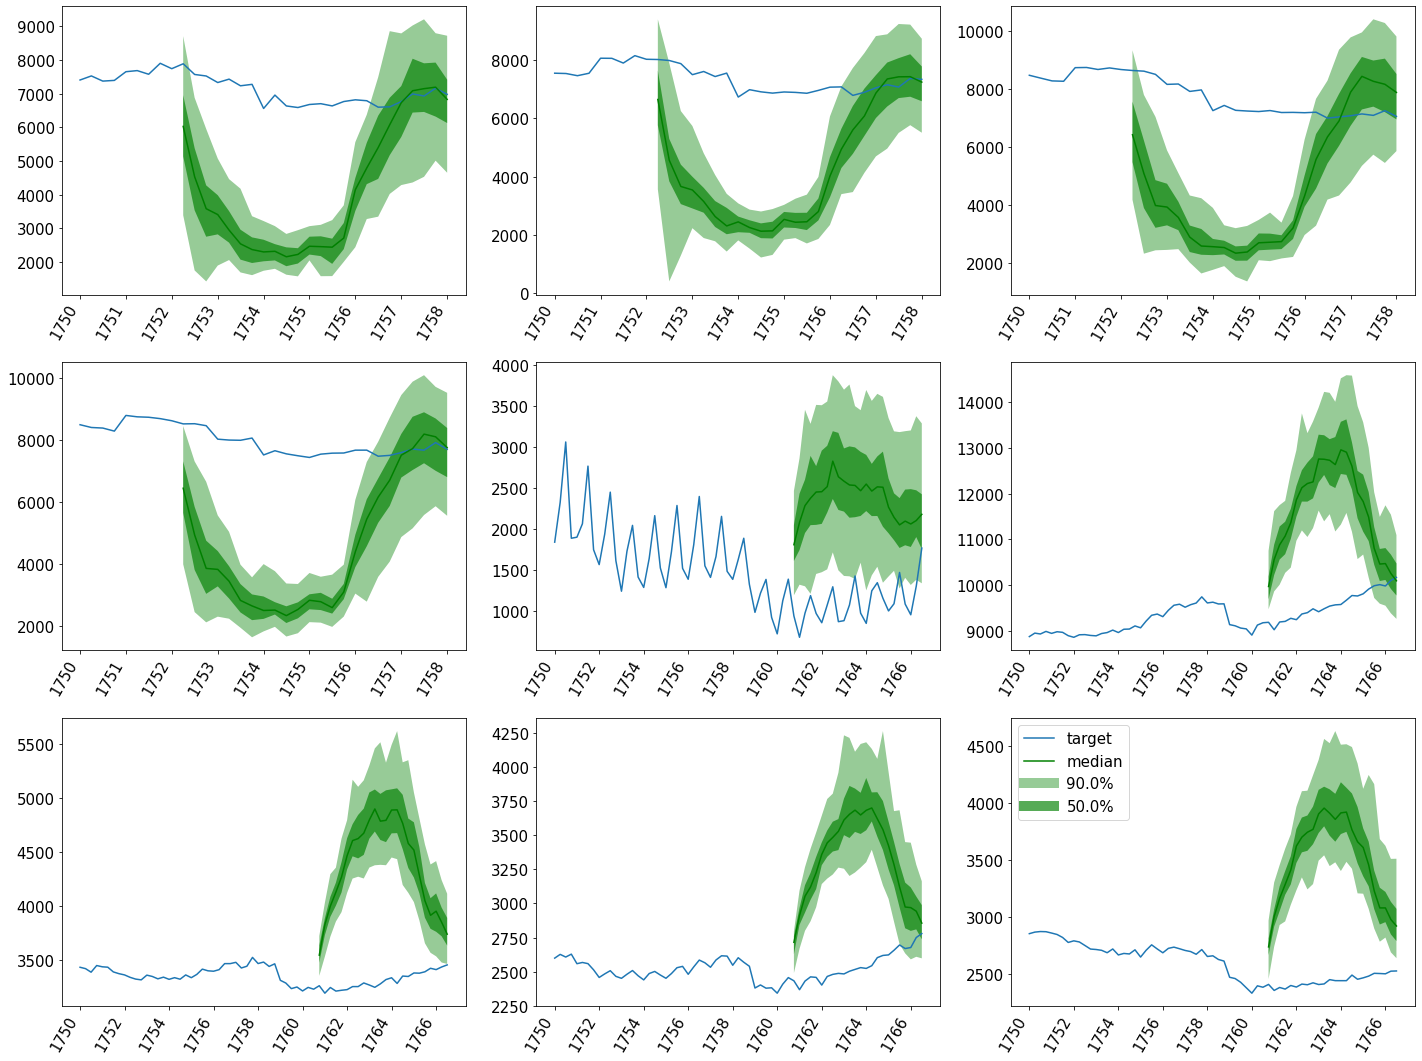

In [130]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## Scaling Experiments

We keep the individual layers of the Transformer unchanged: i.e. 
* the model dimension: context window (effecting lag features);
* the width of the feed-forward layer `dim_feedforward=16`; 
* the number of attention heads `nhead=2`;
* the categorical feature embedding dimension;
* and distribution head.

We examine the change in the test-set metrics as the number of parameters increases with the following three depth scaling approaches:
1. Encoder Scaling: vary the `num_encoder_layers` while `num_decoder_layers` is kept fixed;
1. Decoder Scaling: vary the `num_decoder_layers` while the `num_encoder_layers` is kept fixed;
1. Symmetric Scaling: vary both the `num_encoder_layers` and `num_decoder_layers` but kept equal.

In [51]:
layers = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 48, 56, 64]

### Encoder Scaling

In [ ]:
enc_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        prediction_length=prediction_length,
        context_length=prediction_length*10,
        time_features=time_features,

        nhead=2,
        num_encoder_layers=layer,
        num_decoder_layers=4,
        dim_feedforward=16,
        activation="gelu",


        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=10, accelerator='auto', gpus=1, precision="bf16"),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    enc_metrics.append(agg_metrics.copy())
    
with open("elec_enc_metrics.pkl", "wb") as fp:
    pickle.dump(enc_metrics, fp)

In [3]:
with open("elec_enc_metrics.pkl", "rb") as fp:
    enc_metrics = pickle.load(fp)

Text(0.5, 1.0, 'Encoder Scaling')

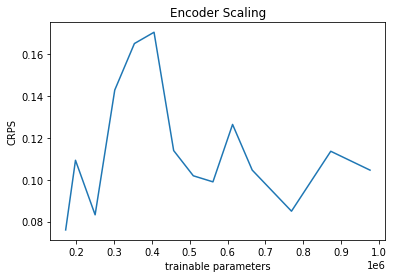

In [4]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["mean_wQuantileLoss"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("CRPS")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

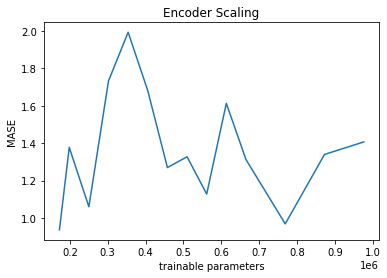

In [7]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["MASE"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MASE")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

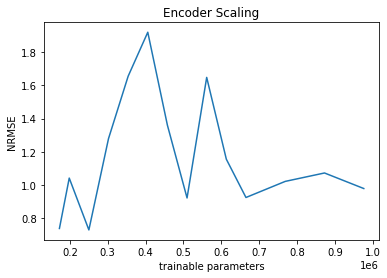

In [6]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["NRMSE"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("NRMSE")
plt.title("Encoder Scaling")

### Decoder Scaling

In [ ]:
dec_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=6,
        num_decoder_layers=layer,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    dec_metrics.append(agg_metrics.copy())
    
with open("elec_dec_metrics.pkl", "wb") as fp:
    pickle.dump(dec_metrics, fp)

In [8]:
with open("elec_dec_metrics.pkl", "rb") as fp:
    dec_metrics = pickle.load(fp)

Text(0.5, 1.0, 'Decoder Scaling')

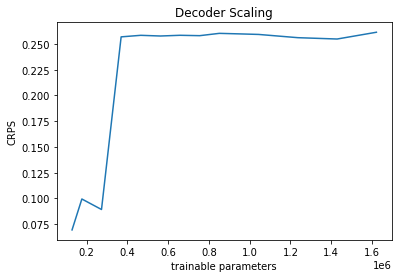

In [9]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in dec_metrics],
    [metrics["mean_wQuantileLoss"] for metrics in dec_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("CRPS")
plt.title("Decoder Scaling")

Text(0.5, 1.0, 'Decoder Scaling')

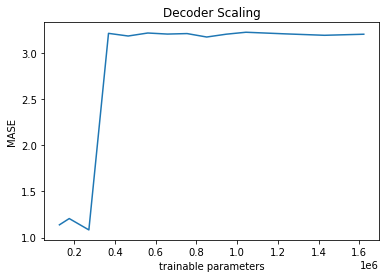

In [10]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in dec_metrics],
    [metrics["MASE"] for metrics in dec_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MASE")
plt.title("Decoder Scaling")

Text(0.5, 1.0, 'Decoder Scaling')

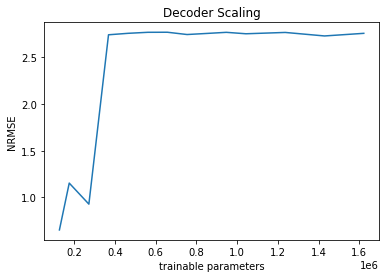

In [11]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in dec_metrics],
    [metrics["NRMSE"] for metrics in dec_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("NRMSE")
plt.title("Decoder Scaling")

### Symmetric Scaling

In [ ]:
sym_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=layer,
        num_decoder_layers=layer,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    sym_metrics.append(agg_metrics.copy())

with open("elec_sym_metrics.pkl", "wb") as fp:
    pickle.dump(sym_metrics, fp)

In [3]:
with open("elec_sym_metrics.pkl", "rb") as fp:
    sym_metrics = pickle.load(fp)

Text(0.5, 1.0, 'Symmetric Scaling')

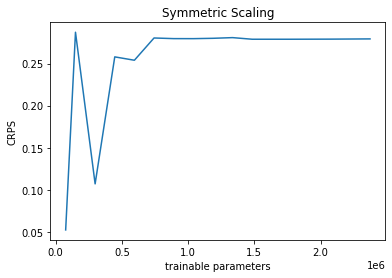

In [4]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in sym_metrics],
    [metrics["mean_wQuantileLoss"] for metrics in sym_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("CRPS")
plt.title("Symmetric Scaling")

Text(0.5, 1.0, 'Symmetric Scaling')

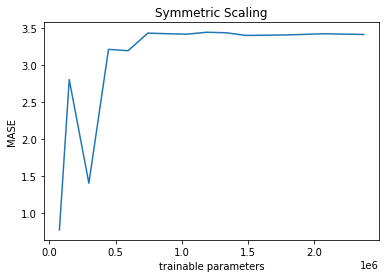

In [5]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in sym_metrics],
    [metrics["MASE"] for metrics in sym_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MASE")
plt.title("Symmetric Scaling")

Text(0.5, 1.0, 'Symmetric Scaling')

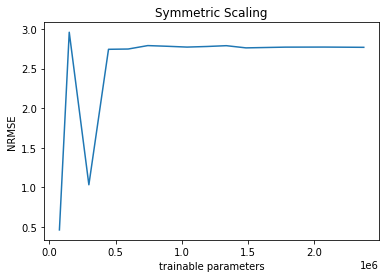

In [16]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in sym_metrics],
    [metrics["NRMSE"] for metrics in sym_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("NRMSE")
plt.title("Symmetric Scaling")